# Comparisons and analysis

This notebook is for getting the simulated data done on the cluster and then doing funky comparisons and analysis

In [10]:
# First Import the packages.
from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib.colors import ListedColormap
from turbo_colormap import *
from scipy import stats
#matplotlib.style.use('ggplot')
import inspect
import os
import csv 
import time

import glob
# import pandas as pd

# Now Import our data from our data folder:

# Get all csv filenames in a folder
all_files = glob.glob("do-not-track/*.csv")
#all_files

# Scorr of Empirical (Experimental) FCM vs SCM of Connectome

This gives a baseline of what the minimum correlation should be like. 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Text(0.05, 0.95, 'SpearmanrResult(correlation=0.3936670530573764, pvalue=2.4789217444587726e-53)')

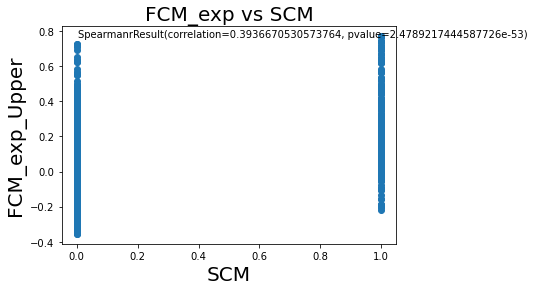

In [31]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Set SCM as Binary
con.weights = con.weights!=0
SCM = con.weights

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

# Comparison of SCorr vs Selected Variable (G = Coupling constant)

 

In [9]:
# Get Scorr csv filenames in a folder
Scorr_files = glob.glob("do-not-track/G[*SCorr*.csv")

SCorr_array = []

# Loop to populate the empty array with the numbers from the Scorr csv files:

for item in Scorr_files:
    a = np.genfromtxt(item)
    SCorr_array.append(a[0])

print(SCorr_array)
print(numpy.amax(SCorr_array))
print(numpy.where(SCorr_array==np.amax(SCorr_array)))

[0.25183795471951126, 0.2716272443899898, 0.29204315531686226, 0.31281840483691375, 0.333216795291562, 0.35477203979431643, 0.3739609898503382, 0.3935377459498965, 0.4100470845685042, 0.42520236143847795, 0.4341526717398768, 0.2749816864385517, 0.30010610412311794, 0.48629892607785286, 0.5034633783887296, 0.5062306434612244, 0.50131179631745, 0.49693194706282307, 0.49477379783371733, 0.4976768764439313, 0.5002732477541347, 0.5002776389723986, 0.4966471188390143, 0.4920569370305489, 0.4876025815125727, 0.48078632305973895, 0.4724713930357501, 0.46322751028092374, 0.45432977563759275, 0.4437164720837825, 0.434023408157803, 0.42337067337347284, 0.4132437720203275, 0.40277945852820274, 0.39188353058552944, 0.3811365785986572, 0.3694672063934634, 0.35788109273706836, 0.34684931467121366, 0.33679254504508255]
0.5062306434612244
(array([15], dtype=int64),)


In [6]:
# Check File order. 
Scorr_files

['do-not-track\\G[0.21]_MouseCortex_Scorr_20200621-230132_.csv',
 'do-not-track\\G[0.22]_MouseCortex_Scorr_20200621-225737_.csv',
 'do-not-track\\G[0.23]_MouseCortex_Scorr_20200621-225935_.csv',
 'do-not-track\\G[0.24]_MouseCortex_Scorr_20200621-225836_.csv',
 'do-not-track\\G[0.25]_MouseCortex_Scorr_20200621-230011_.csv',
 'do-not-track\\G[0.26]_MouseCortex_Scorr_20200621-230122_.csv',
 'do-not-track\\G[0.27]_MouseCortex_Scorr_20200621-230015_.csv',
 'do-not-track\\G[0.28]_MouseCortex_Scorr_20200621-224009_.csv',
 'do-not-track\\G[0.29]_MouseCortex_Scorr_20200621-224111_.csv',
 'do-not-track\\G[0.30]_MouseCortex_Scorr_20200621-223904_.csv',
 'do-not-track\\G[0.31]_MouseCortex_Scorr_20200622-001142_.csv',
 'do-not-track\\G[0.32]_MouseCortex_Scorr_20200622-001240_.csv',
 'do-not-track\\G[0.33]_MouseCortex_Scorr_20200622-001517_.csv',
 'do-not-track\\G[0.34]_MouseCortex_Scorr_20200622-004951_.csv',
 'do-not-track\\G[0.35]_MouseCortex_Scorr_20200622-004900_.csv',
 'do-not-track\\G[0.36]_M

Text(0.5, 1.0, 'Scorr vs G')

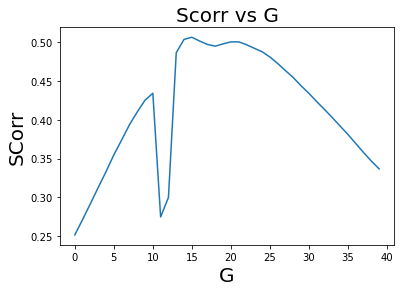

In [7]:
# Graph it: 

plt.plot(SCorr_array)
plt.xlabel('G', fontsize=20)
plt.ylabel('SCorr', fontsize=20)
plt.title('Scorr vs G', fontsize=20)

# Looking at a simulation run

In [2]:
# Ye dunno why having the closing square bracket messes up glob glob. 
Sim_run_files = glob.glob("do-not-track/G[0.36*.csv")
Sim_run_files

['do-not-track\\G[0.36]_MouseCortex_FCM_20200622-005002_.csv',
 'do-not-track\\G[0.36]_MouseCortex_Params_20200622-005002_.csv',
 'do-not-track\\G[0.36]_MouseCortex_Scorr_20200622-005002_.csv',
 'do-not-track\\G[0.36]_MouseCortex_Tseries_20200622-005002_.csv']

In [3]:
# Read file import data
#df = pd.read_csv(all_files[11],delimiter="\t",header=None)
# Genfromtxt gives us a np array. 
df = np.genfromtxt(Sim_run_files[-1],delimiter="\t")

bold_time = df[0]
bold_data = df[1:]

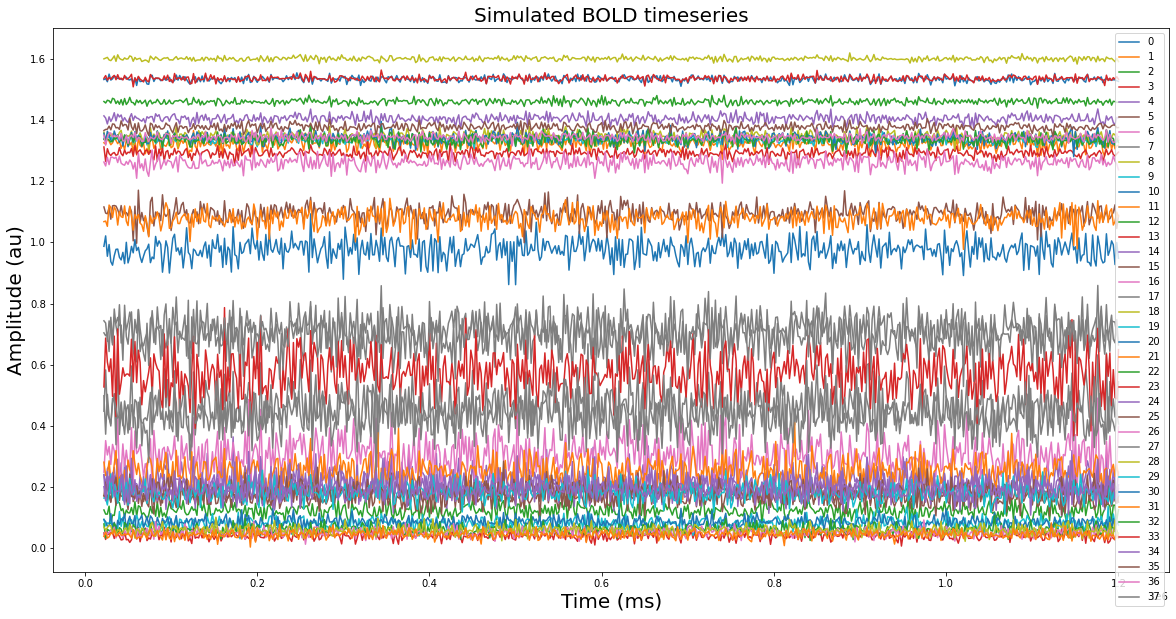

In [4]:
# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
for tseries in bold_data:
    plt.plot(bold_time,tseries)

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))

In [5]:
Scorra = np.genfromtxt(Sim_run_files[-2])
Scorra

array([5.06230643e-01, 2.27352168e-92])

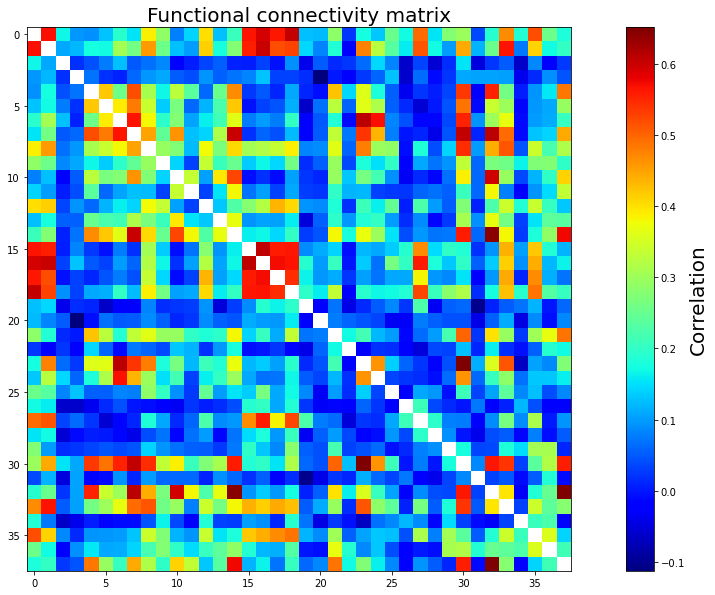

In [13]:
# Plot Simulated FCM
FCM_sim = np.genfromtxt(Sim_run_files[0],delimiter="\t")

# ListedColormap(turbo_colormap_data)
cs=plt.imshow(FCM_sim, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

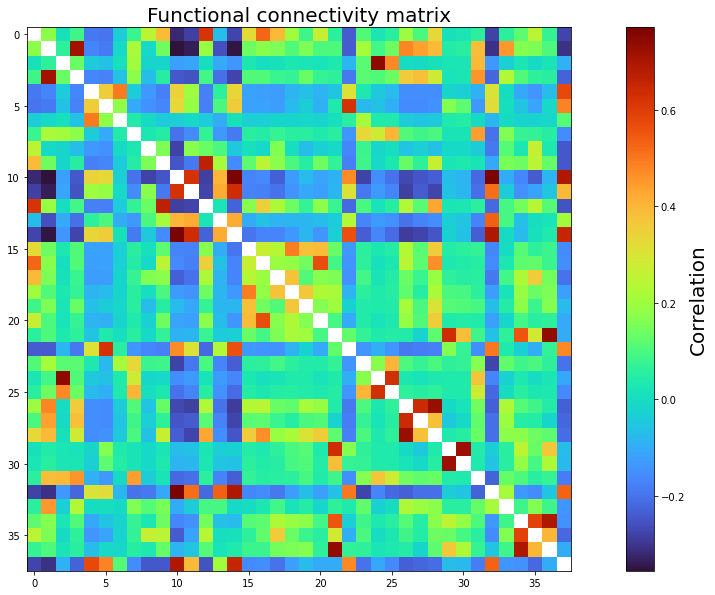

In [11]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")

# Comparing FC_experimental Vs FC_Simulation with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

cs=plt.imshow(FCM_exp, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

Text(0.05, 0.95, 'SpearmanrResult(correlation=0.277555654200391, pvalue=6.69169706217845e-14)')

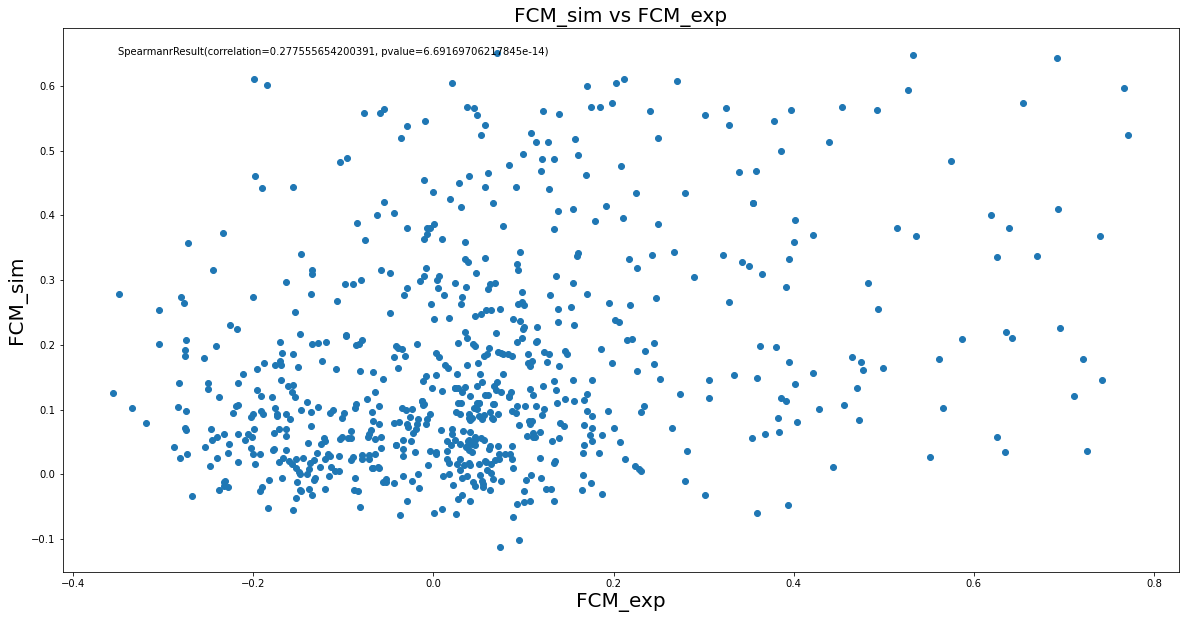

In [49]:
FCM_Exp_U = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
FCM_Sim_U = FCM_sim[np.triu_indices(FCM_sim.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCM_sim vs FCM_exp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')